# Overall
This note book shows the procedure to produce the scalability performance plots from DALiuGE.

The result set includes 61 tests on the Magnus / Galaxy cluster at the [Pawsey supercomputing center](https://www.pawsey.org.au/), and 2 tests on the [Tianhe-2 supercomputer](https://en.wikipedia.org/wiki/Tianhe-2).

In [1]:
import os, sys, string, time
from datetime import datetime
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import itertools
%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 8.0)
plt.rcParams['xtick.labelsize'] =14
plt.rcParams['ytick.labelsize'] =14

## Schema of the dataset
    0.  user name (e.g. Tom or Jerry)
    1.  facility (e.g. galaxy)
    2.  pipeline (e.g. lofar_std)
    3.  time (e.g. 2016-08-22T11-52-11/)
    4.  # of compute nodes
    5.  # of drops
    6.  git commit id
    7.  logical graph unroll_time
    8.  translation_time
    9.  pg_spec_gen_time
    10. created_session_at_all_nodes_time
    11. graph_separation_time
    12. push_sub_graphs_to_all_nodes_time
    13. created_drops_at_all_nodes_time
    14. Num_pyro_connections_at_all_nodes
    15. created_pyro_conn_at_all_nodes_time
    16. triggered_drops_at_all_nodes_time
    17. execution time
    18. # of islands

## Load the dataset

In [2]:
csv_file = 'presult_7_Sep_2016.csv'
df = pd.read_csv(csv_file, header=None)

num_tests, num_attr = df.shape
print("In total {0} tests and {1} attributes recorded".format(num_tests, num_attr))
# just show the first three tests
df[0:3]

In total 61 tests and 19 attributes recorded


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,cw,galaxy,lofar_test_64x128,2016-09-06T23-33-21,60,133830,fceac646a6dd06d5c80e47787bd87dbd971374ea,10.396,4.018,0.096,0.048,2.07899999619,1.567,1.224,-1,None,0.081,403.456,1
1,cw,galaxy,lofar_test_16x32,2016-09-06T22-27-27,60,8886,fceac646a6dd06d5c80e47787bd87dbd971374ea,0.177,0.208,0.006,0.064,0.0939998626709,0.806,0.104,-1,None,0.036,402.385,1
2,cw,galaxy,lofar_test_64x128,2016-09-06T23-33-08,30,133830,fceac646a6dd06d5c80e47787bd87dbd971374ea,10.410,4.017,0.095,0.024,1.9880001545,1.285,1.402,-1,None,0.065,403.513,1


## Set the filter
Show tests that met some query conditions

In [3]:
def filter_data(num_nodes=None, gt_num_drops=None, lt_num_drops=None, 
                git_commit=None, user=None, pipeline=None, 
                gt_test_date=None, lt_test_date=None, lt_trans_time=None, 
                gt_trans_time=None, gt_drop_create_time=None,
                gt_completion_time=None, lt_completion_time=None, filter_none=[16], num_islands=None):
    
    col_list = list(string.ascii_lowercase[0:19])
    rt = pd.DataFrame(df.values, columns=col_list)
    cond = []
    if (num_nodes != None):
        cond.append('e == %d' % num_nodes)
    if (num_islands != None):
        cond.append('s == %d' % num_islands)
    if (gt_num_drops != None):
        cond.append('%s >= %d' % (col_list[5], gt_num_drops))
    if (lt_num_drops != None):
        cond.append('%s <= %d' % (col_list[5], lt_num_drops))
    if (lt_trans_time != None):
        cond.append('%s <= %d' % (col_list[8], lt_trans_time))
    if (gt_trans_time != None):
        cond.append('%s >= %d' % (col_list[8], gt_trans_time))
    if (lt_completion_time != None):
        cond.append('%s <= %d' % (col_list[17], lt_completion_time))
    if (gt_completion_time != None):
        cond.append('%s >= %d' % (col_list[17], gt_completion_time))
    if (git_commit != None):
        cond.append('%s == "%s"' % (col_list[6], git_commit))
    if (user != None):
        cond.append('%s == "%s"' % (col_list[0], user))
    if (pipeline != None):
        cond.append('%s == "%s"' % (col_list[2], pipeline))
    if (gt_test_date != None):
        cond.append('%s >= "%s"' % (col_list[3], gt_test_date))
    if (lt_test_date != None):
        cond.append('%s <= "%s"' % (col_list[3], lt_test_date))
    for rm in filter_none:
        cond.append('%s != "None"' % col_list[rm])
        cond.append('%s != -1' % col_list[rm])
    rt = pd.DataFrame(rt.query(' & '.join(cond)).values)
    return rt.sort_values(by=[5, 14])
#test_filter = filter_data(60, lt_num_drops=10000, lt_test_date='2016-08-29T21-00-56')
#test_filter = filter_data(user='cw', filter_none=[17], gt_test_date='2016-08-31T00-00-56')
df = filter_data(filter_none=[6,7,8])
test_filter = filter_data(filter_none=[5],
                         gt_test_date='2016-08-31T00-00-56', lt_trans_time=30)
test_filter.shape
#test_filter

(48, 19)

## Plot 1
The first set of graphs show the time spend on varoius metrics when we increase the number of Drops or Drop relationships given a fixed set of nodes (e.g. 30 or 60).

After filtering as shown above, we also want to make sure all data values of our intersted columns are of "numeric" type, and we also want to sort the dataset based on the number of Drops as this plot requires

In [4]:
col_list = [5] + list(range(7, 18))
ttr = test_filter[col_list].sort_values(by=[5])
ttr[col_list] = ttr[col_list].apply(pd.to_numeric, errors='coerce')

Then, we let Pandas do the heavy-lifting of data aggregation and calculation

In [5]:
def plot_time_vs_drops(runs_data, num_nodes, pyro_time=False):
    """
    pyro_time: include time for establishing pyro relationships?
                default=True
    """
    col_list = [5] + list(range(7, 18))
    ttr = runs_data[col_list].sort_values(by=[5])
    ttr[col_list] = ttr[col_list].apply(pd.to_numeric, errors='coerce')
    
    yv = ttr.groupby([5]).mean()
    x = yv.index.values
    x_label = '# of Drops'
    y1 = yv.ix[:, 7:13].values
    y4 = yv.ix[:, 16:17].values
    
    ye = ttr.groupby([5]).std()
    ye1 = ye.ix[:, 7:13].values
    ye4 = ye.ix[:, 16:17].values.astype(float)

    labels_1 = ['unroll', 'translate', 'pg_spec', 'session', 'separation', 'push_graph', 'created_drop']
    marker_1 = ['o', 'v', '^', '8', 's', 'x', 'D']
    labels_2 = ['trigger', 'execution']
    marker_2 = ['+', 'D']#marker_1[0:5]
    f = plt.figure(1)
    #f.suptitle("Time cost when increasing the {1} running on {0} nodes".format(num_nodes, x_label), fontsize=17)
    ax1 = plt.subplot(111)
    ax1.set_yscale("log")
    for i in range(len(labels_1)):
        lines = plt.errorbar(x, y1[:, i], linewidth=2, label=labels_1[i], yerr=ye1[:, i],
                 marker=marker_1[i], markersize=9, markerfacecolor='none', markeredgewidth=2)
        lines[0].set_markeredgecolor(lines[0].get_color())
    #plt.legend(loc='best', fontsize=14)
    plt.ylabel('Seconds', fontsize=15)
    plt.xlabel(x_label, fontsize=15)
    for i in range(len(labels_2)):
        lines = plt.errorbar(x, y4[:,i], linewidth=2, label=labels_2[i], yerr=ye4[:, i],
                 marker=marker_2[i], markersize=9, markerfacecolor='none', markeredgewidth=2)
        lines[0].set_markeredgecolor(lines[0].get_color())
    orientation = 'center right' if pyro_time else 'center right'
    plt.legend(loc='best', fontsize=15)

First, try 30 nodes

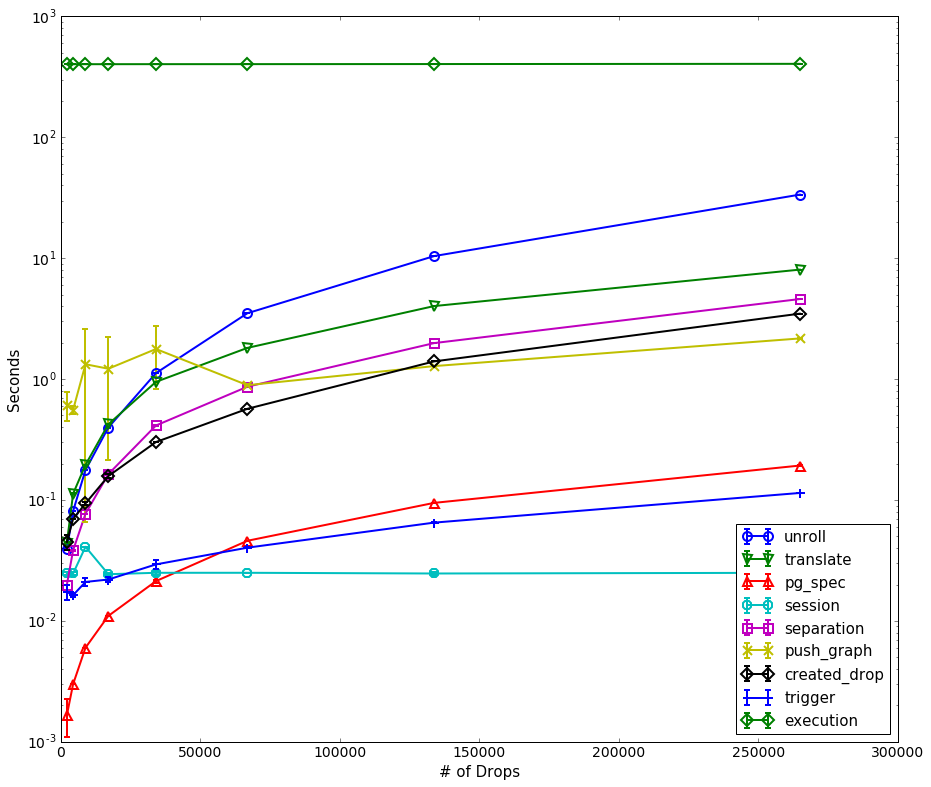

In [6]:
nb_nodes = 30
plt.rcParams['figure.figsize'] = (15.0, 13.0)
plot_time_vs_drops(filter_data(num_nodes=nb_nodes, user='cw', filter_none=[17], 
                               gt_test_date='2016-08-31T00-00-56', lt_trans_time=20), num_nodes=nb_nodes, 
                               pyro_time=False)


Check the "accelerate rate" of the unroll and translate checkpoints

In [7]:
df_de = filter_data(num_nodes=nb_nodes, user='cw', filter_none=[7, 8, 17])[[5,7,8]]
df_de = df_de.apply(pd.to_numeric, errors='coerce')
dfdede = df_de.groupby(5).mean()
dfdede

,7,8
5,,
2226,0.039333,0.044333
4446,0.081000,0.112667
8886,0.177000,0.195333
17078,0.397667,0.423000
34150,1.121000,0.949000
66918,3.506333,1.812000
133830,10.410000,4.018334
264902,33.557000,8.044000


In [8]:
ut = dfdede.values # ut represents "unroll" and "translate"
unroll_mean = np.mean(np.divide(ut[:,0][1:], ut[:,0][0:-1]))
trans_mean = np.mean(np.divide(ut[:,1][1:], ut[:,1][0:-1]))
print("increasing rate: unroll: {0}, translate: {1}".format(unroll_mean, trans_mean))

increasing rate: unroll: 2.66149504285, translate: 2.1161333078


Now try 60 nodes...

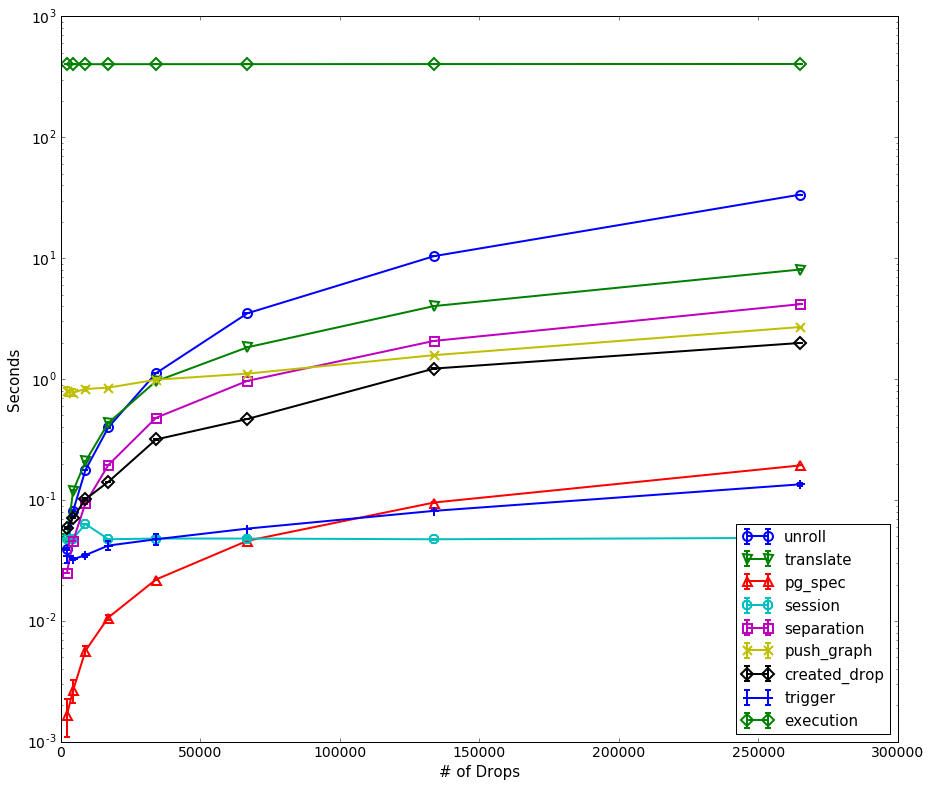

In [9]:
nb_nodes = 60
plot_time_vs_drops(filter_data(num_nodes=nb_nodes, user='cw', filter_none=[17], 
                               gt_test_date='2016-08-31T00-00-56', lt_trans_time=20), num_nodes=nb_nodes, 
                               pyro_time=False)
plt.rcParams['figure.figsize'] = (20.0, 8.0)

## Plot 2
The association between # of Drops and the cost of cross-node communication under different # of Nodes


In [10]:
def plot_comm_vs_drops():
    markers = itertools.cycle(('o', 'v', '.', 'o', '*'))
    
    nb_drops = [499, 220, 348, 690, 1202, 2226, 4446, 8886, 17078, 34150, 66918, 133830, 264902]
    edge_cuts_30 = [593, 1038, 1151, 2034, 3584, 4192, 6475, 8531, 18927, 18608, 30135, 58615, 116436]
    edge_cuts_60 = [1035, 1819, 2552, 3045, 4077, 7689, 9545, 13333, 25918, 38970, 83067, 61884, 324568]
    ls = plt.plot(nb_drops, edge_cuts_30, label='30 nodes edgecuts', marker=markers.next(), 
                 markersize=10, markeredgewidth=2, markerfacecolor='none', linewidth=3, color='r')
    ls[0].set_markeredgecolor(ls[0].get_color())
    ls = plt.plot(nb_drops, edge_cuts_60, label='60 nodes edgecuts', marker=markers.next(), 
                 markersize=10, markeredgewidth=2, markerfacecolor='none', linewidth=3, color='y')
    ls[0].set_markeredgecolor(ls[0].get_color())
    plt.ylabel('Cross-node cost', fontsize=15)
    plt.xlabel('# of Drops', fontsize=15)
    plt.legend(loc='upper left', fontsize=15)

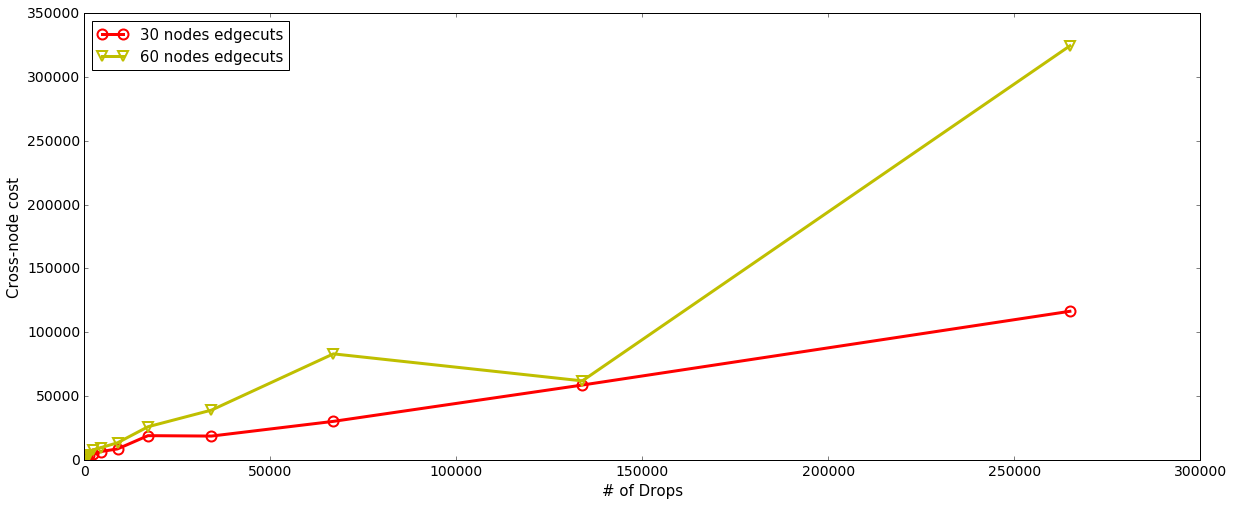

In [11]:
plot_comm_vs_drops()

## Plot 3
the time spend on varoius metrics when we increase the # of nodes given a fixed set of Drops. Since the level of # of nodes is not so many, it is best to use a bar chart to illustrate this.

In [12]:
df30 = filter_data(filter_none=[17], gt_test_date='2016-08-31T00-00-56', 
                   gt_num_drops=None, num_nodes=30, user='cw', 
                   gt_completion_time=0, lt_trans_time=100)[[5, 17]]

In [13]:
df60 = filter_data(filter_none=[17], gt_test_date='2016-08-31T00-00-56', 
                   gt_num_drops=None, num_nodes=60, user='cw', 
                   gt_completion_time=0, lt_trans_time=100)[[5, 17]]

In [14]:
dt1 = df30[17].astype(float)
df30_1 = pd.DataFrame({'17_30': list(dt1)}, index=list(df30[[5]].values[:,0]))
df30_mean = df30_1.groupby(df30_1.index).mean()
df30_err = df30_1.groupby(df30_1.index).std()
df30_mean

,17_30
2226,402.300667
4446,402.361667
8886,402.409333
17078,402.486667
34150,402.712000
66918,402.898667
133830,403.527333
264902,405.190000


In [15]:
dt2 = df60[17].astype(float)
df60_1 = pd.DataFrame({'17_60': list(dt2)}, index=list(df60[[5]].values[:,0]))
df60_mean = df60_1.groupby(df60_1.index).mean()
df60_err = df60_1.groupby(df60_1.index).std()
df60_mean

,17_60
2226,402.426333
4446,402.345667
8886,402.418333
17078,402.475667
34150,402.668000
66918,402.828667
133830,403.453667
264902,403.994000


In [16]:
both_df = df30_mean.join(df60_mean).sort_index()
both_df_err = df30_err.join(df60_err).sort_index()
both_df

,17_30,17_60
2226,402.300667,402.426333
4446,402.361667,402.345667
8886,402.409333,402.418333
17078,402.486667,402.475667
34150,402.712000,402.668000
66918,402.898667,402.828667
133830,403.527333,403.453667
264902,405.190000,403.994000


In [17]:
both_df_err

,17_30,17_60
2226,0.040129,0.059534
4446,0.088036,0.053501
8886,0.018583,0.061232
17078,0.042063,0.026274
34150,0.021000,0.031225
66918,0.010599,0.010214
133830,0.048128,0.006807
264902,0.010440,0.026000


In [18]:
both_df_err.mean()

17_30    0.034872
17_60    0.034348
dtype: float64

In [19]:
nodes_30 = both_df[['17_30']].values.flatten()
nodes_30_err = both_df_err[['17_30']].values.flatten()

In [20]:
nodes_60 = both_df[['17_60']].values.flatten()
nodes_60_err = both_df_err[['17_60']].values.flatten()

In [21]:
x_tick_labels = [str(x) + ' Drops' for x in sorted(both_df.index.values)]

In [22]:
N = len(nodes_30)

In [23]:
min_exec_time = 397.0

The above minimum executiont time is [calculated](https://github.com/SKA-ScienceDataProcessor/dfms/blob/master/dfms/dropmake/pg_generator.py#L613) as the longest path of the physical graph, which is indepdent of the number of Drops in our test graph series. This is because we only change the Degree of Parallelism (DoP) of our graphs by increasing or decreasing the graph "breadth" rather than its "depth". This theoretical minimum represents a lower bound for any scheduling or graph partitioning algorithms. More importantly, it can be used as benchmark metrics, against which we measure the overhead associated with the DALiuGE execution framework.

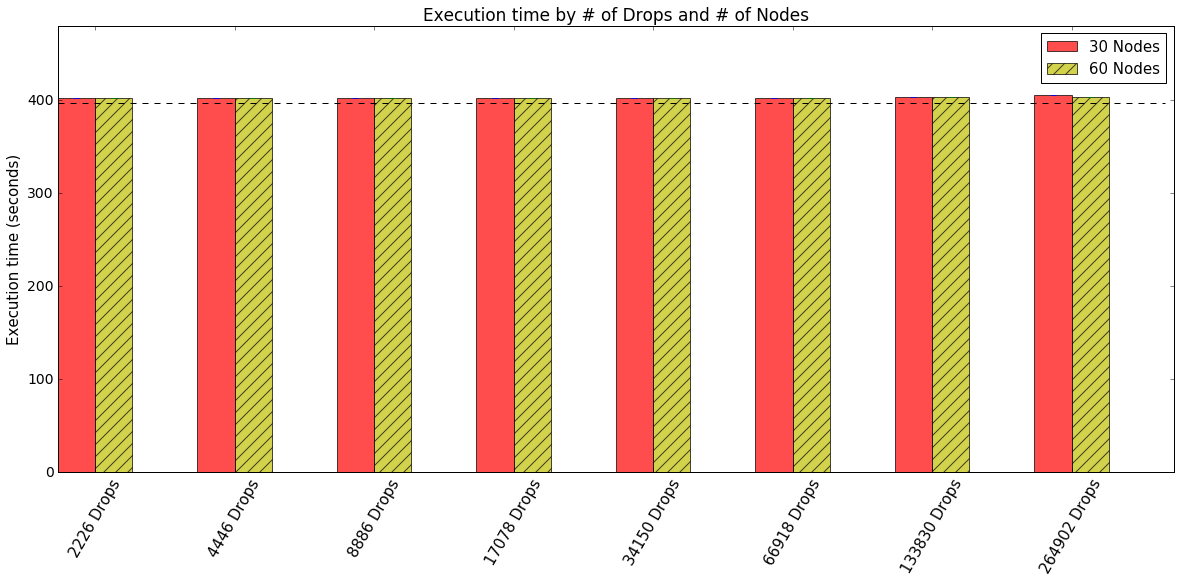

In [24]:
width = 0.4
ind = np.arange(N) * 1.5
b1 = plt.bar(ind, nodes_30, width, color='r', yerr=nodes_30_err, alpha=0.7)
b2 = plt.bar(ind + width, nodes_60, width, color='y', yerr=nodes_60_err, hatch="//", alpha=0.7)
plt.plot([0, ind[-1] + 3.5 * width], [min_exec_time, min_exec_time], color='k', linestyle='--', linewidth=1)

plt.ylim((0, 480))
plt.xticks(ind + width, x_tick_labels, fontsize=15, rotation=60)
plt.ylabel('Execution time (seconds)', fontsize=15)
plt.title('Execution time by # of Drops and # of Nodes', fontsize=17)
plt.legend((b1, b2), ('30 Nodes', '60 Nodes'), loc='upper right', fontsize=15)

Now we plot the same metrics but add two extra runs of 1 million Drops on 150 nodes (with multiple data islands).

Before we do that, have a look at the execution time for the two 1 million Drop tests.

In [25]:
m1_df = filter_data(gt_num_drops=1000000, lt_num_drops=2000000)
dfv = m1_df[[5, 4, 17,18]].values
m1_df = pd.DataFrame(dfv, columns=['# of Drops', '# of Nodes', 'Execution time', '# of Islands'])
m1_df

,# of Drops,# of Nodes,Execution time,# of Islands
0,1054086,150,406.632,5
1,1054086,150,410.039,1


Now add their execution times into the plot

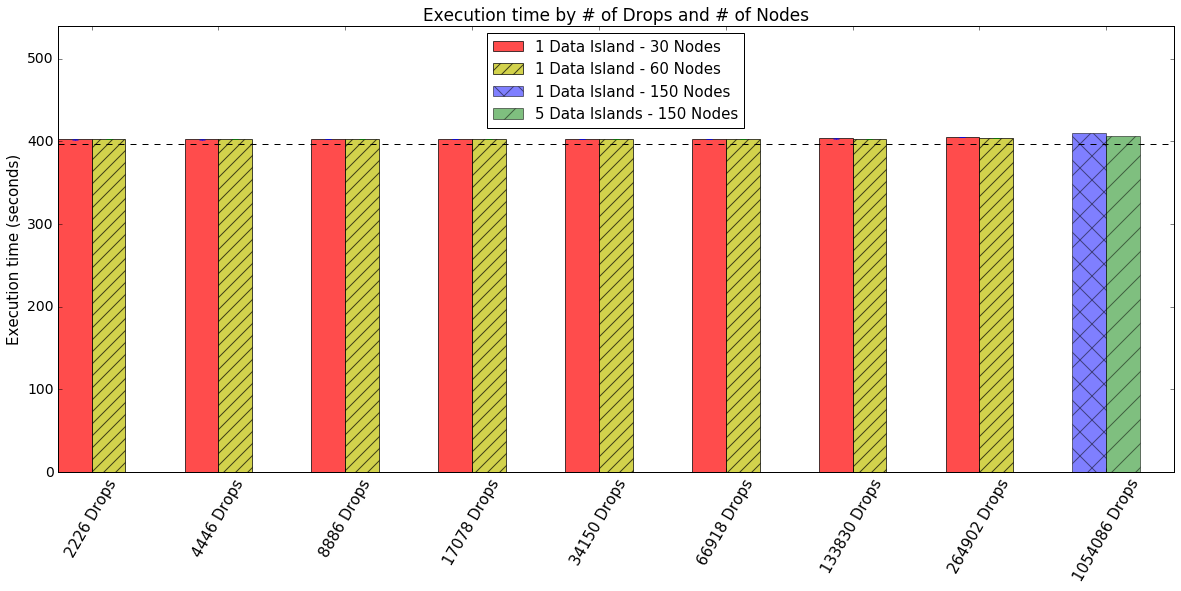

In [26]:
width = 0.4
ind = np.arange(N) * 1.5
b1 = plt.bar(ind, nodes_30, width, color='r', yerr=nodes_30_err, alpha=0.7)
b2 = plt.bar(ind + width, nodes_60, width, color='y', yerr=nodes_60_err, hatch="//", alpha=0.7)


b3 = plt.bar([ind[-1] + 1.5], [m1_df.values[1][2]], width, color='b', hatch="x", alpha=0.5)
b4 = plt.bar([ind[-1] + 1.5 + width], [m1_df.values[0][2]], width, color='g', hatch="/", alpha=0.5)

plt.ylim((0, 540))
indx = list(ind)
indx.append(ind[-1] + 1.5)
indx = np.array(indx)
x_tick_labels_ex = x_tick_labels + ['1054086 Drops']
plt.xticks(indx + width, x_tick_labels_ex, fontsize=15, rotation=60)
plt.xlim((0, indx[-1] + 3 * width))
plt.plot([0, indx[-1] + 3 * width], [min_exec_time, min_exec_time], color='k', linestyle='--', linewidth=1)
plt.ylabel('Execution time (seconds)', fontsize=15)
plt.title('Execution time by # of Drops and # of Nodes', fontsize=17)
plt.legend((b1, b2, b3, b4), 
           ('1 Data Island - 30 Nodes', '1 Data Island - 60 Nodes', 
            '1 Data Island - 150 Nodes', '5 Data Islands - 150 Nodes'), 
           loc='upper center', fontsize=15)

Now plot the framework overhead, which is defined as:

$$ 
\frac{Measured\_execution\_time - Theoretical\_execution\_time} {Number\_of\_Drops} 
$$

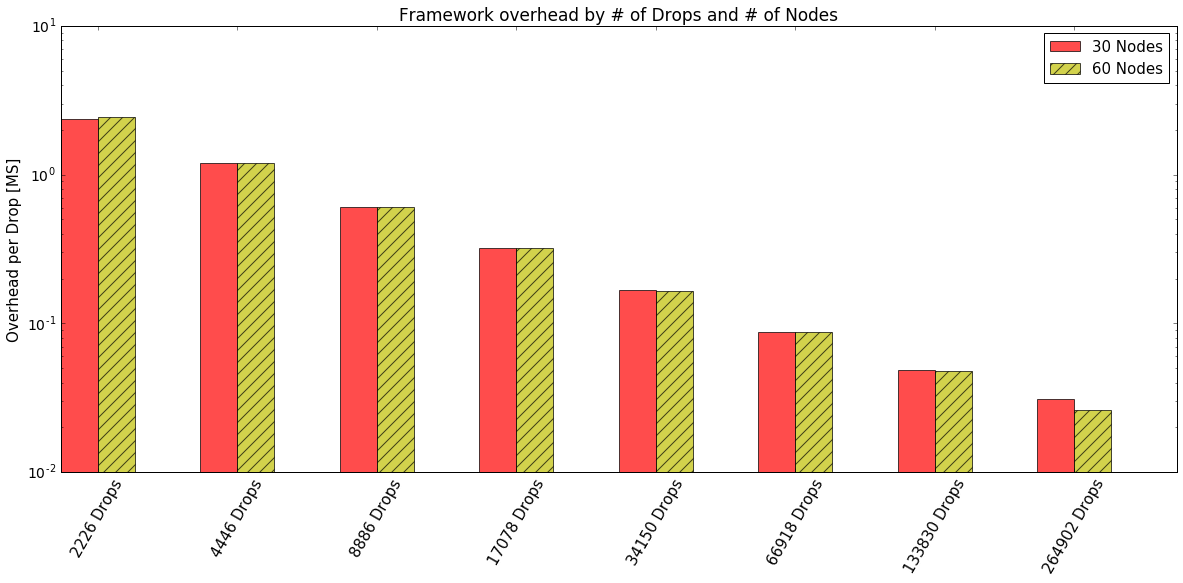

In [27]:
bda = (both_df - min_exec_time).values
eff_30 = np.divide(bda[:,0], both_df.index.values)
eff_60 = np.divide(bda[:,1], both_df.index.values)

width = 0.4
ind = np.arange(N) * 1.5
plt.yscale('log')
b1 = plt.bar(ind, eff_30 * 1e3, width, color='r', alpha=0.7)
b2 = plt.bar(ind + width, eff_60 * 1e3, width, color='y',hatch="//", alpha=0.7)

plt.xticks(ind + width, x_tick_labels, fontsize=15, rotation=60)
plt.ylabel('Overhead per Drop [MS]', fontsize=15)
plt.title('Framework overhead by # of Drops and # of Nodes', fontsize=17)
plt.legend((b1, b2), ('30 Nodes', '60 Nodes'), loc='upper right', fontsize=15)

Again, we include two extra runs of 1 million Drops on 150 nodes (with multiple data islands) in the the overhead plot 

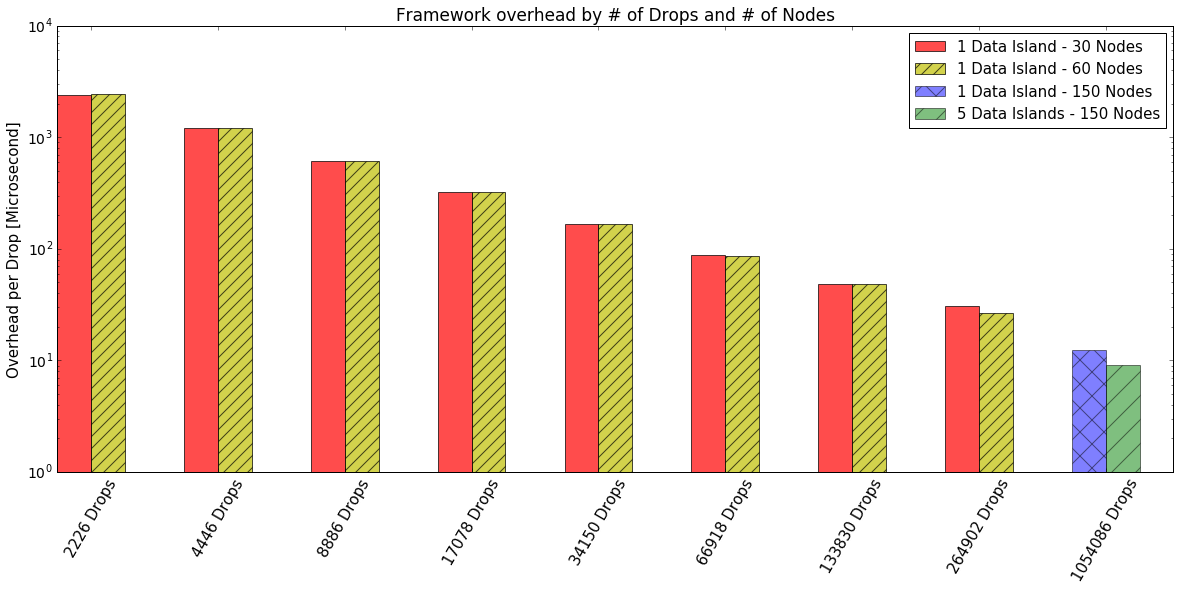

In [28]:
bda = (both_df - min_exec_time).values
eff_30 = np.divide(bda[:,0], both_df.index.values)
eff_60 = np.divide(bda[:,1], both_df.index.values)

width = 0.4
ind = np.arange(N) * 1.5
plt.yscale('log')
b1 = plt.bar(ind, eff_30 * 1e6, width, color='r', alpha=0.7)
b2 = plt.bar(ind + width, eff_60 * 1e6, width, color='y',hatch="//", alpha=0.7)

one_island_time = m1_df.values[1][2]
five_island_time = m1_df.values[0][2]
num_1m_drops = m1_df.values[0][0]
b3 = plt.bar([ind[-1] + 1.5], [(one_island_time - min_exec_time) / num_1m_drops * 1e6], 
             width, color='b', hatch="x", alpha=0.5)
b4 = plt.bar([ind[-1] + 1.5 + width], [(five_island_time - min_exec_time) / num_1m_drops * 1e6], 
             width, color='g', hatch="/", alpha=0.5)

indx = list(ind)
indx.append(ind[-1] + 1.5)
indx = np.array(indx)
x_tick_labels_ex = x_tick_labels + ['%d Drops' % num_1m_drops]
plt.xticks(indx + width, x_tick_labels_ex, fontsize=15, rotation=60)
plt.xlim((0, indx[-1] + 3 * width))

#plt.xticks(ind + width, x_tick_labels, fontsize=15, rotation=60)
plt.ylabel('Overhead per Drop [Microsecond]', fontsize=15)
plt.title('Framework overhead by # of Drops and # of Nodes', fontsize=17)
#plt.legend((b1, b2), ('30 Nodes', '60 Nodes'), loc='upper right', fontsize=15)
plt.legend((b1, b2, b3, b4), 
           ('1 Data Island - 30 Nodes', '1 Data Island - 60 Nodes', 
            '1 Data Island - 150 Nodes', '5 Data Islands - 150 Nodes'), 
           loc='upper right', fontsize=15)

## Plot 4 - Event timeseries
Plot the event/message intensity over the time axis (time series of events). 
First for input, we need three log files: xx_execState.log, xx_session_running.log, xx_state.log

Step 1 - convert state into a Pandas dataframe (state event type, time)

In [29]:
dt_pattern = '%Y-%m-%dT%H:%M:%S,%f'
def get_timestamp(date_time):
    """
    microsecond precision
    """
    epoch = time.mktime(time.strptime(date_time, dt_pattern))
    return epoch
    #return datetime.strptime(date_time, dt_pattern).microsecond / 1e6 + epoch

In [30]:
ex_st_file = 'event_logs/64x128_execState.log'
st_file = 'event_logs/64x128_state.log'
ss_file = 'event_logs/64x128_session_running.log'

def go_thru_logs(st_file, session=False):
    ret = []
    with open(st_file) as esf:
        for line in esf.readlines():
            line = line.strip()
            s_sp = line.split()
            tstr = s_sp[0].split(':')[1] + 'T' + s_sp[1]
            ts = int(get_timestamp(tstr))
            if (session):
                ret.append(ts)
            else:
                node = int(line.split('/')[1])
                event = int(s_sp[-1])
                ret.append((ts, node, event))
    if (session):
        return max(ret)
    else:
        return ret

In [31]:
dst = go_thru_logs(st_file)
aest = go_thru_logs(ex_st_file)
ets = [dst, aest]

In [32]:
stt = go_thru_logs(ss_file, True)

In [33]:
def plot_event_timesries(ets, labels, stt, filters):
    """
    ets: a list of event numpy arrays, for each event array, the first column is the absoluate timestamp
    labels: a list of event labels/types
    stt: start time (integer)
    """
    bbmm = 1000
    tmp = []
    for a in ets:
        b = np.asarray(a)
        b0 = b[:,0] - stt
        bmin = np.min(b0)
        tmp.append((b, b0, bmin))
        bbmm = bmin if (bmin < bbmm) and (bmin < 0) else bbmm
        
    colors = itertools.cycle(('b', 'r', 'g'))
    max_end = 0
    line_styles = itertools.cycle(('solid', 'dashed'))
    for i, (b, b0, bmin) in enumerate(tmp):
        if (bbmm < 0):
            b0 -= bbmm
        fi = filters[i]
        if (fi is not None):
            x = b[:,2]
            b0 = b0[np.where(x == fi)] # each element is a relative timestamp (not an interval)
        ttt = np.max(b0)
        if ttt > max_end:
            max_end = ttt
        bc = np.bincount(b0)
        ii = np.nonzero(bc)[0]
        tt = zip(ii,bc[ii])
        xy = np.asarray(tt)
        x = xy[:,0]
        y = xy[:,1]
        plt.semilogy(x, y, label=labels[i], color=colors.next(), linewidth=1.5, 
                     linestyle=line_styles.next())
    plt.grid(True)
    plt.xlabel('Time in seconds', fontsize=15)
    plt.ylabel('# of events per second', fontsize=15)
    plt.legend(loc='upper right', fontsize=15)
    plt.title('Rate of Events/Status Changes over Time (133,830 Drops on 60 nodes)', fontsize=17)
    return max_end

489

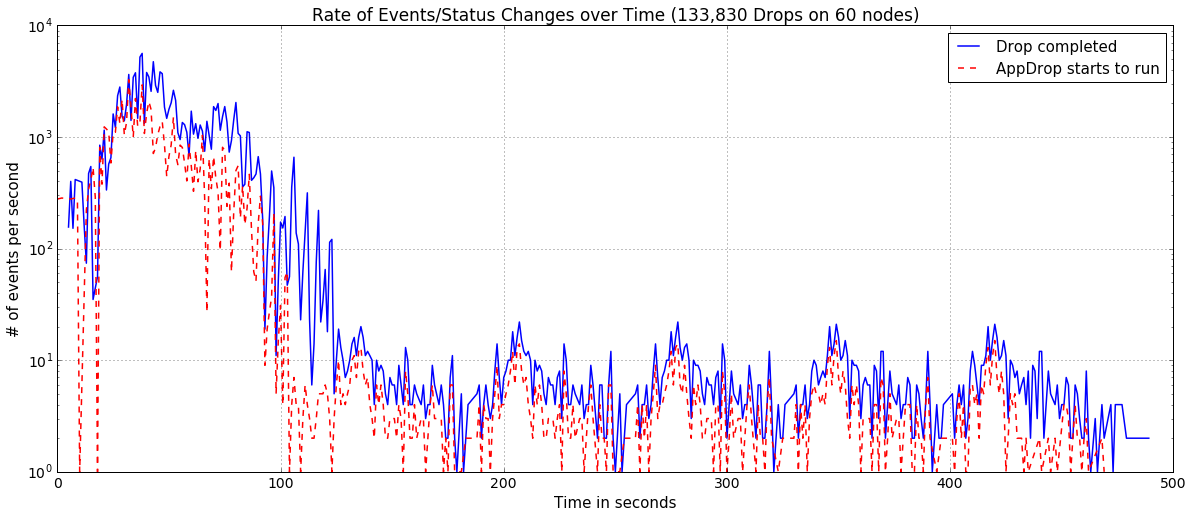

In [34]:
filters = [None, 1]
labels = ['Drop completed', 'AppDrop starts to run']
max_end = plot_event_timesries(ets, labels, stt, filters)
max_end

## Plot 5 - Event heatmap
In this type of plot, the color map represents the number of events, the X axis is the time, the Y axis is the compute node

In [35]:
def calc_event_heatmap(ets, labels, stt, filters, num_nodes):
    """
    ets: a list of event numpy arrays, for each event array, the first column is the absoluate timestamp
    labels: a list of event labels/types
    stt: start time (integer)
    """
    bbmm = 1000
    tmp = []
    for a in ets:
        b = np.asarray(a)
        b0 = b[:,0] - stt
        bmin = np.min(b0)
        tmp.append((b, b0, bmin))
        bbmm = bmin if (bmin < bbmm) and (bmin < 0) else bbmm
    matrix = np.zeros((num_nodes - 1, max_end + 1), dtype=np.float)
    for i, (b, b0, bmin) in enumerate(tmp):
        if (bbmm < 0):
            b0 -= bbmm
        fi = filters[i]
        b1 = b[:,1]
        if (fi is not None):
            x = b[:,2]
            ind = np.where(x == fi)
            b0 = b0[ind] # each element is a relative timestamp (not an interval)
            b1 = b1[ind]
        #print(len(b0), len(b1))
        for j, bt in enumerate(b0):
            matrix[b1[j] - 1][bt] += 1
    
    return matrix

In [36]:
mat = calc_event_heatmap(ets, labels, stt, filters, 60)

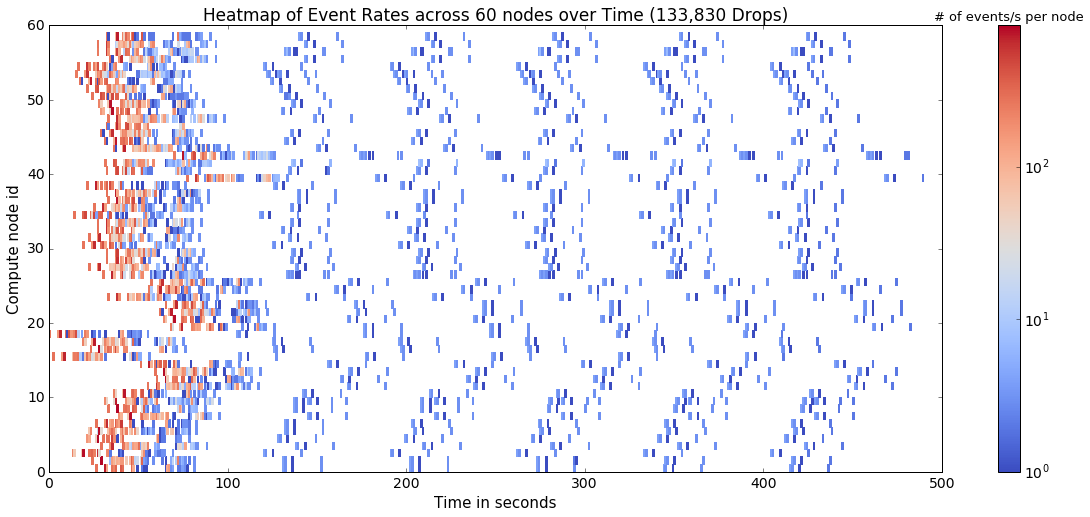

In [37]:
plt.pcolor(mat, cmap=plt.cm.coolwarm, norm=mpl.colors.LogNorm())
cbar = plt.colorbar()
#cbar.ax.xaxis.tick_top()
cbar.ax.xaxis.set_label_position('top')
cbar.ax.set_xlabel('# of events/s per node', fontsize=13)
plt.ylabel('Compute node id',fontsize=15)
plt.xlabel('Time in seconds', fontsize=15)
plt.title('Heatmap of Event Rates across 60 nodes over Time (133,830 Drops)', fontsize=17)

In the above plot, the X axis is time, the Y axis is the compute node identifier. The colorbar represents the # of events at that time (second) on one of the 60 compute nodes.

## Large Scale Test

In the large scale test, we use the logical graphs that no longer contain the "Global Sky Model" Data Drop.

In [38]:
lst_one = filter_data(gt_num_drops=2000000, lt_completion_time=800, num_islands=1)
lst_five = filter_data(gt_num_drops=2000000, lt_completion_time=800, num_islands=5)
lst_one = lst_one.sort_values(by = [5,4,18]) # sort by drop, nodes, and islands
lst_five = lst_five.sort_values(by = [5,4,18])


In [39]:
lst_1 = lst_one[[4, 5, 17]]

In [40]:
lst_5 = lst_five[[4, 5, 17]]

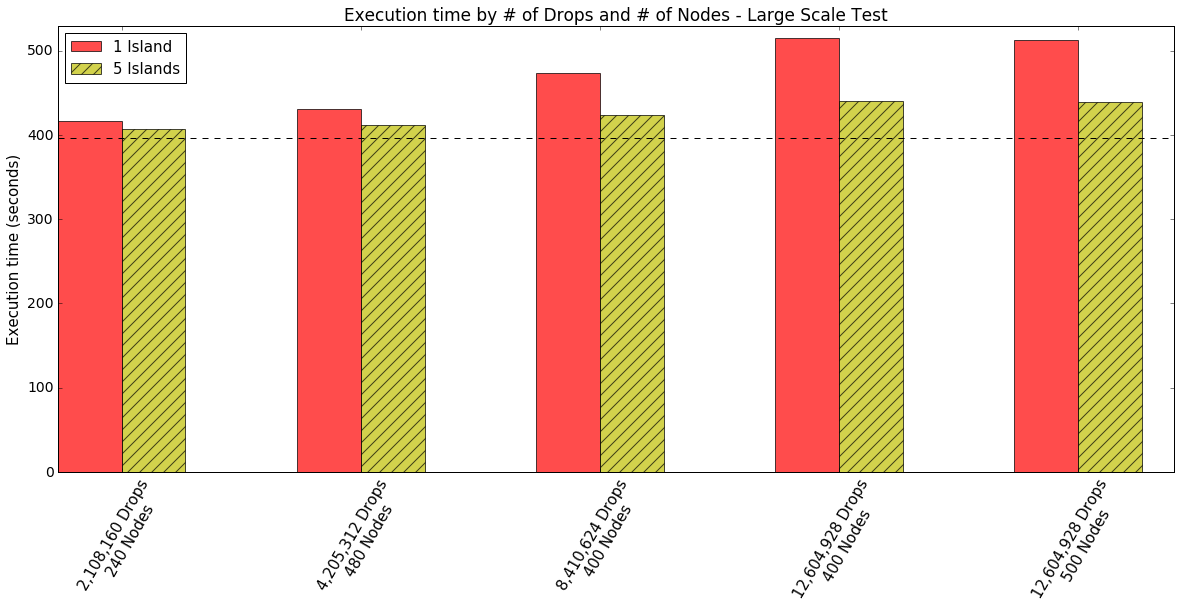

In [41]:
import locale
locale.setlocale(locale.LC_ALL, 'en_AU')
N = len(lst_five)
width = 0.4
ind = np.arange(N) * 1.5
island_1 = lst_1.values.T[2].astype(np.float32)
island_5 = lst_5.values.T[2].astype(np.float32)
x_tick_labels = [locale.format("%d", x, grouping=True) +\
                 ' Drops\n {0} Nodes'.format(y) for x, y in zip(lst_1.values.T[1], lst_1.values.T[0])]

b1 = plt.bar(ind, island_1, width, color='r', alpha=0.7)
b2 = plt.bar(ind + width, island_5, width, color='y', hatch="//", alpha=0.7)
plt.plot([0, ind[-1] + 2.5 * width], [min_exec_time, min_exec_time], color='k', linestyle='--', linewidth=1)

plt.ylim((0, 530))
plt.xticks(ind + width, x_tick_labels, fontsize=15, rotation=60)
plt.ylabel('Execution time (seconds)', fontsize=15)
plt.title('Execution time by # of Drops and # of Nodes - Large Scale Test', fontsize=17)
plt.legend((b1, b2), ('1 Island', '5 Islands'), loc='upper left', fontsize=15)

Now plot the overhead

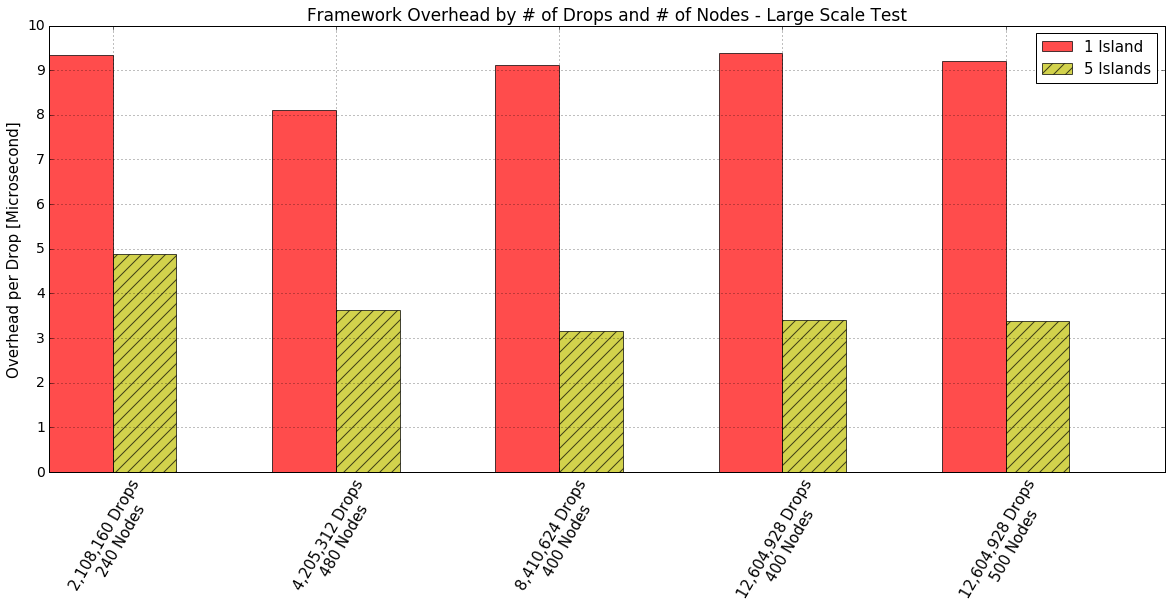

In [42]:
N = len(lst_five)
width = 0.4

ind = np.arange(N) * 1.4
eff_1 = np.divide(island_1 - min_exec_time, lst_1.values.T[1]) * 1e6
eff_5 = np.divide(island_5 - min_exec_time, lst_5.values.T[1]) * 1e6
x_tick_labels = [locale.format("%d", x, grouping=True) +\
                 ' Drops\n {0} Nodes'.format(y) for x, y in zip(lst_1.values.T[1], lst_1.values.T[0])]

b1 = plt.bar(ind, eff_1, width, color='r', alpha=0.7)
b2 = plt.bar(ind + width, eff_5, width, color='y', hatch="//", alpha=0.7)
plt.grid(True)
plt.ylim((0, 10))
plt.xticks(ind + width, x_tick_labels, fontsize=15, rotation=60)
plt.yticks(range(11))
plt.ylabel('Overhead per Drop [Microsecond]', fontsize=15)
plt.title('Framework Overhead by # of Drops and # of Nodes - Large Scale Test', fontsize=17)
plt.legend((b1, b2), ('1 Island', '5 Islands'), loc='best', fontsize=15)

## Tianhe-2 Test
This section shows the result of running the test LOFAR physical graph with 4 million Drops on 480 Tianhe-2 compute nodes.

Note in this test we have used a "shorter" physical graph since we "accidentally" set the number of iterations for the AWImager cycle to 3 instead of 5. As a result, the minumum execution time becomes 253 seconds rather than 397 seconds.

In [43]:
csv_file = 'islands_tianhe2.csv'
df = pd.read_csv(csv_file, header=None)

In [44]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,bqlao,tianhe2,lofar_nsm_512x512,2016-09-24T06-34-48,471,4201728,None,91.496,82.838,22.264,0.287,30.845,60.410,9.705,-1,None,7.067,0.0,399.829
1,bqlao,tianhe2,lofar_nsm_512x512,2016-09-24T06-10-05,468,4201728,None,90.611,82.362,4.222,0.615,155.913,42.491,36.446,-1,None,6.215,0.0,422.542


In [45]:
dfv = df[[7,8,9,10,11,12,13,16,18]].values

In [46]:
df2 = pd.DataFrame(dfv, columns=['Unroll', 
                                 'Translate', 'Gen pgspec', 
                                 'Create session', 'Separate graph', 
                                 'Push graph', 'Create drop',
                                'Trigger drop', 'Execution time'], index=['5 Islands', '1 Island'])

In [47]:
df2

,Unroll,Translate,Gen pgspec,Create session,Separate graph,Push graph,Create drop,Trigger drop,Execution time
5 Islands,91.496,82.838,22.264,0.287,30.845,60.410,9.705,7.067,399.829
1 Island,90.611,82.362,4.222,0.615,155.913,42.491,36.446,6.215,422.542


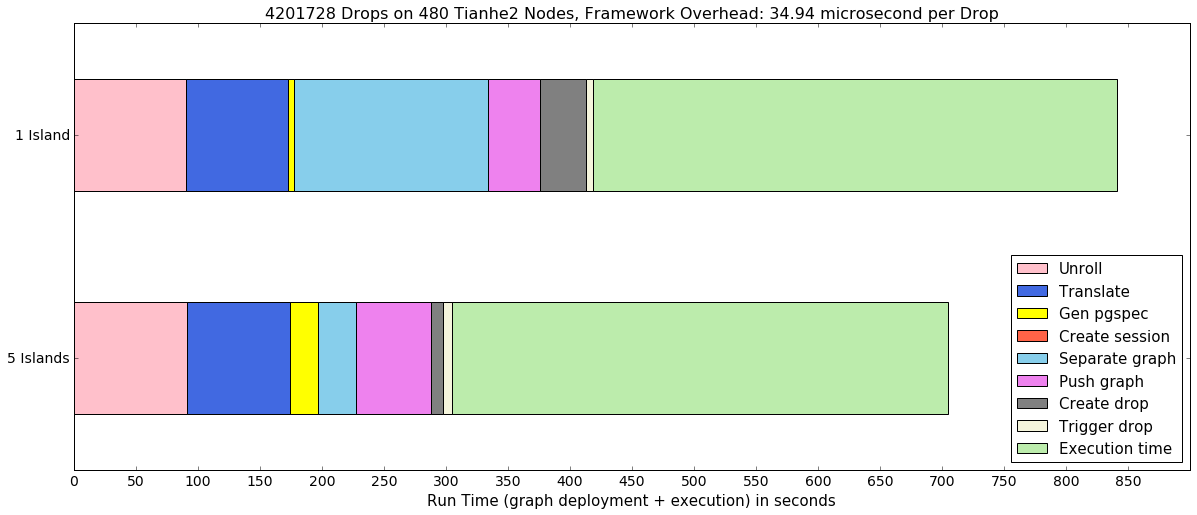

In [48]:
min_exec_time = 253.0
from itertools import cycle, islice
eff = (df2.iloc(0)[0][-1] - min_exec_time) / df.iloc(0)[0][5] * 1e6
my_colors = list(islice(cycle(['pink', 'royalblue', 'yellow', 'tomato', 'skyblue', 'violet', 'grey', 'beige', 'lightsage']), None, len(df2.columns)))
a = df2.plot.barh(stacked=True, color=my_colors)
a.set_title("%d Drops on 480 Tianhe2 Nodes, Framework Overhead: %.2f microsecond per Drop" % (df.iloc(0)[0][5], eff), fontsize=16)
a.legend(loc='best', fontsize=15)
a.set_xlabel("Run Time (graph deployment + execution) in seconds", fontsize=15)
a.set_xticks(list(np.arange(18) * 50))